In [17]:
%matplotlib notebook

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation
import IPython
import IPython.display
import IPython.core.display
from os.path import join, exists
from os import makedirs

output_dir = '../../outf/HW2-4'
if not exists(output_dir):
    makedirs(output_dir)

In [18]:
def make_animation(plotx, E, xl=(0, 1), yl=(0, 1), inter=25, display=False):
    '''
    takes a graph and motion of vertexes in 2D and returns an animation
    E: list of edges (each edge is a pair of vertexes)
    plotx: a matrix of states ordered as (x1, y1, x2, y2, ..., xn, yn) in the rows and time in columns
    xl and yl define the display boundaries of the graph
    inter is the interval between each point in ms
    '''
    fig = mpl.figure.Figure()
    mpl.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=xl, ylim=yl)
    ax.grid()

    list_of_lines = []
    for i in E: #add as many lines as there are edges
        line, = ax.plot([], [], 'o-', lw=2)
        list_of_lines.append(line)

    def animate(i):
        for e in range(len(E)):
            vx1 = plotx[2*(E[e][0]-1),i]
            vy1 = plotx[2*(E[e][0]-1)+1,i]
            vx2 = plotx[2*(E[e][1]-1),i]
            vy2 = plotx[2*(E[e][1]-1)+1,i]
            list_of_lines[e].set_data([vx1,vx2],[vy1,vy2])
        return list_of_lines

    def init():
        return animate(0)

    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=inter, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    if(display==True):
        IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))
    return ani

In [19]:
class SecondOrderControl:
    def __init__(self, G, poses, zref, time=15, dt=0.01, k=0.5):
        self.G = G
        self.zref = zref
        self.time = time
        self.dt = dt
        self.k = k
        self.N = G.number_of_nodes()

        self.T = int(time / dt)
        self.u = np.zeros((self.T, self.N, 2))
        self.x = np.zeros((self.T, self.N, 2))
        self.x[0] = poses

        self.L = nx.laplacian_matrix(G).toarray()
        self.D = nx.incidence_matrix(G, oriented=True).toarray()

    def draw_initial_conditions(self):
        pos = {}
        plt.figure()
        for i, position in enumerate(self.x[0]):
            pos[i+1] = position
        pos_shadow = {key: (value[0] + 0.005, value[1] + 0.005) for key, value in pos.items()}
        nx.draw(self.G, pos_shadow, with_labels=False, node_size=600, node_color='none', edgecolors='gray', edge_color='gray', width=3.0, alpha=0.5)

        nx.draw(self.G, pos, with_labels=True, node_size=600, edge_color='red', width=2.0, linewidths=3.0, edgecolors='black', node_color='white', font_size=12, font_weight='bold')
        plt.title('Initial Conditions')
        plt.show()

    def run_simulation(self):
        for t in range(1, self.T):
            self.u[t - 1] = -self.k * self.L @ self.x[t - 1] + self.k * self.D @ self.zref
            self.x[t] = self.x[t - 1] + self.u[t - 1] * self.dt

    def plot_results(self, filename=None, display=True):
        E = list(self.G.edges())
        X = np.zeros((2 * self.N, self.T))
        for i in range(self.T):
            for j in range(self.N):
                X[2 * j, i] = self.x[i, j, 0]
                X[2 * j + 1, i] = self.x[i, j, 1]

        ani = make_animation(X, E, xl=(0, 5), yl=(0, 5), inter=10, display=display)
        if filename:
            writervideo = animation.FFMpegWriter(fps=20, codec='h264', extra_args=['-pix_fmt', 'yuv420p'])
            ani.save(filename, writer=writervideo)

        return ani

## Initial Condition

<IPython.core.display.Javascript object>


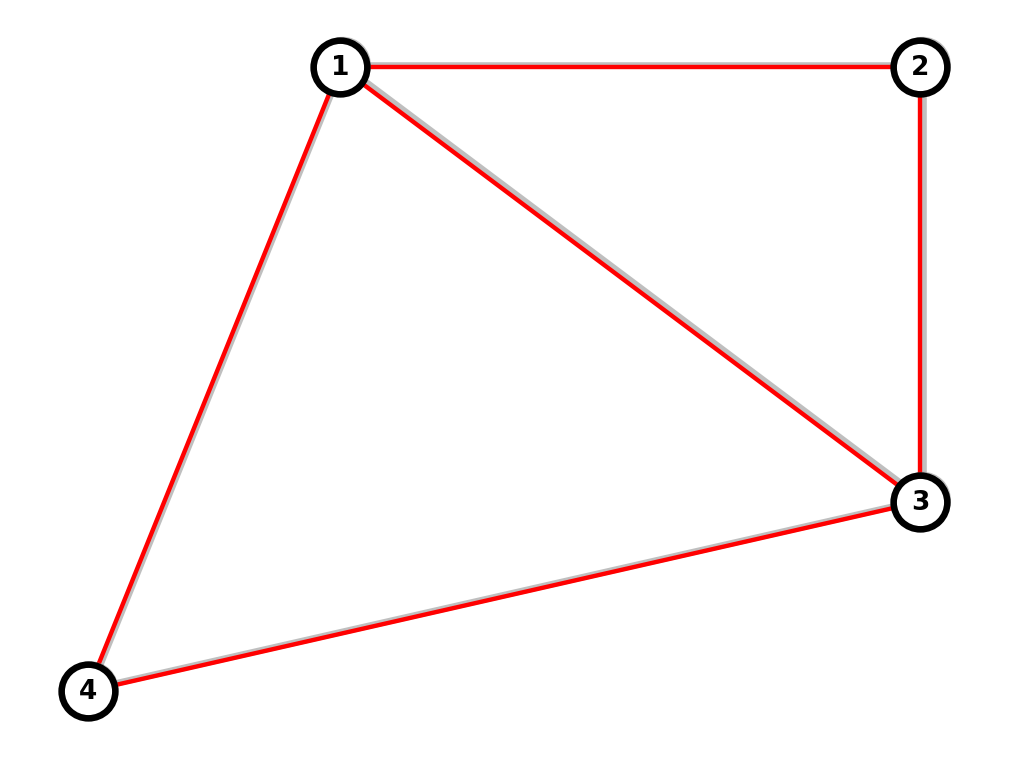

In [9]:
N = 4
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4])
G.add_edges_from([(1, 2), (2, 3), (1, 3), (1, 4), (3, 4)])
a=7/2-np.sqrt(7/8)
poses=np.array([[3,4],[4,4],[4,3],[a,a]])
zref = np.array([[1, 1],[1, 1], [np.sqrt(2), np.sqrt(2)], [1.5, 1.5],  [1.5, 1.5]])

control = SecondOrderControl(G, poses,zref)
control.draw_initial_conditions()

## Simulation

In [20]:
control.run_simulation()
control.plot_results(filename=join(output_dir,'simulations_animation.gif'))

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABWW1tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DIVliIQAb/70oPgUz6FLysxWyh+ac0W1/obcG3SyUAAAAwAAAwAAD6w3kXK6/MNIAAADACYAC0Qq
C3C4AEywMRtRUh30U8qi9BvMgjSbkZ5DpV17Ude0fgllIKoSwW+yPD+IFOdujgppAF8nZS02pyGJ
ageVFcuLgJMIhp1RS81v+Ze5fsLoUeiUIsPv+6C6H/oTqZvDbSqHws2agIY7oycsnjIFk2VRk+Ol
OntWJbeuAR7fofGiLCsQ3xvusFUR7GHsH1GaEMapOXX2bex/G3SLHOiIa1L3qjUx+YwQ+esuMRbM
b7lweY4lBmbugT8NgHmgaNmoIb3S5nLrnjq6v7NwM+AyD0Fx2tkcqOuzkODUzI2LzpcUFW9Byzb9
W0hId6AFMqTBgo8opbNyoe7dOsgb6jXXmOY/n02yxxKm2+xS611u+nQOY+52ORA6LKhMebfiurvH
D0LbECKQ9Eg/r7CxsNn6k+lZaxGSpurKGbvp2MYvAR+lLaf3NAkbqxMdHGNaESGgxe33ubqAjpNO
y1PcVRGfnDSj/ZUJHZMC9ccPw9jNpE0SrCV9wdLfLKUju/f/5rRzf7XV+E5YJ151Y7wYA962TMLj
8pwGSkN48JJJCEq9Ep8zEmDgFud+Oa//tYN+DJ80jMzNw0QwXZu/Mr0XD6kkIPAmfRy1EK69agjA
qeRMnWsTj19WFB1i8E8x5FKTvelOJJmwZGFGuRwhhD1br0ZCElHacUylMJ2PllE9de4yRJiKqfN9
cBGzhNtr0zN1JRQkMvX1MyvuzzFhMPaJJ2kr10azbuQIg+kqXDxM3FgoObpINCwbwpCnH8gNl+ln
N0YznbmOgqQqv0k64kCvkltYdirMgcb/4P1ymvA+ighzux8iRa04E0h2RmV0gRt5k4+uAgvowfUk
sNfFYkfJHMx1DazB0GPLfkAHJno44tMhsiw4537x4kaCJw119cWA/zicByJMBrT285Zwwi7ViGon
M7Zfl4cqaxIVbupoBHeT8WHKB03eCJvRPU8x/OmDoHPOs063Lrpm4obYzyMfs4zpjvEKRJQDjbav
JaCVmnnCN9rfJrprPGpFIO+3Q9qjmA5xezzgl9JIaC6C3CMPJyFZyfMyqNMgmQ2mtb4neesvs/jf
TsM1EajUlEGEdglxvAzq8ubKR4KgZrwgA6iOICErr6rKm5LZk6QTx56oTgw+EddVhoUcTB4Z4s3E
x7yBrWnqDCZTUDf84YPmrVeEtq18Vj7JoTdcZEzqHFNXB1dkt0OWxVLYIwINSINLuym8TPQfY2KZ
8DrlPlEjxQ4pfSQKu44zEw1iOh3ngh6BNLJ4dzNqxWXW6Dh7dNirmjg0C6eZ+IarXXfZBJs7GQsZ
icOpV5XhW1xNZ/n2qEWhciqzUh7yzplO7mZIQ4Twxir35hlrNsQNhw2mZsBZn+tXgYdWXkTcYi6N
89TtOaTWbcXNp13gqPixadyAW9cyxhEIsrLbO8VN5849F4cpJcogGLnCuKhc8bBj1orjdO+DdrEZ
EbqeEk0V9iBEjnAbyPjlBbu7G6w8gpgP6ETwkJEhybkF2dICxFXCgpoHM7/fuQGWANV3g6JXKZUb
YVTw21whTn3qT04piFXIUpZIIhJdu4iFzXnyCQ6HxK+s21GA2v/p0MtphWL8DcFa3O5Tq6DBTXFe
Aga89ai/JtQzQjwHsSWVj+zuvmILuv1TOB89axC2h73b3NxPUbWYLYjZ1pJU4RKFiFQTrDO3pQLF
qBR8gHyASyBHV2zXJMmSyNneZ4QBgGmxLsxAA56/tGOU3jkRVJSAJYMbnsevmnAe/8kLoN/8OTQ0
vEuk/2/+Q3dfq9Qv1ky/cwxsgW7Gzx0mqwB3g0ZJ8BIs3fhdWkLN/qtnB3roBLKOYREWAuYX39fP
47np56+GGBLzDfiSWBmEg/bEcgsuGJpeDfeeyAeqT5PMo9TZEFzHHjSu1UZRyP0TcRtyOIq0Z7Oo
EiAvvABadcqU/giqdCrdGHBWRUNPOMfpZpaCQHjYEh+tDaWQEB5wds4Y15puHUSVASyCjnnF9IrV
0IydBjFFIG/mPHcWT0cH2wKGIACilM4l7jgHN4IemjHeOYrtwqDQre6HSsO2t361HFFY+G+nCugh
nFoTgkIWCP93XQLRIK/b0EC6DicM+zmTFjg9t3wvh60OmH2lpIROpDl1dSwH7O8e9qY39/XSCcmz
6obI9bDf7oAmda6PT23EswIin7oUfKq6TMyPJp7LtMreLB4EyVKx8L2ah3bG9oBbXFPXvmjELOt7
qSEFwf2WM65ZzCyLQ2HJeNx7AS7NE0XLwiDGbOKEdWmS5EsPb11czBaCrBZqwk3KR2B3dYofHOmg
Lmz2G8c2M9k5wQPzH5cSIyfjoMOVgBbxp18fKgf1f+XBl8Z3e6AXTsH3ybGqkSOICpde95kedT0H
3lEAfK3szJ+R2QO3OmPVJoc5QpXqPtP657FxzdAvRUKMukAjVe6gchpcWZ+UQ319HXsQ518oi978
+0IIx1AkFP2/8SBouvuEZ3B/5pwP/VwoHhvPBcszE+TWqDsHLKxXrnW9Ai7xWqBEUeMj+viQf8TD
Hyd9ECYkUeSb38ceMpvSOqHAN2fVypJHigWMnhGcRzaCkQZ/+9AV9qU/s6+znRBOh9CC2BcFCCTA
9Zpw5/NtMaaih8f+4rP160r7k0dG4mqVWtk6997rXZvl8RGdkJaWv9aLymX8sm4i/xrr/ApJYbUP
zoMeZOdWelpXmJHX39EbgVcC++pVbv3keLOxLZtKyRKUFXueoaOnU1WYuEqbj1ZbvPP/zSTTQjS0
9/ysUbIQix9FnDvxp6IM7gAWQhz4rYAtzItIadzQP65zkZyJmgnfmxJhf4sskiRgYpcVkUHRGwFl
7y/wMMk8XwQQ8dTgNR+rH

## Complete graph

<IPython.core.display.Javascript object>


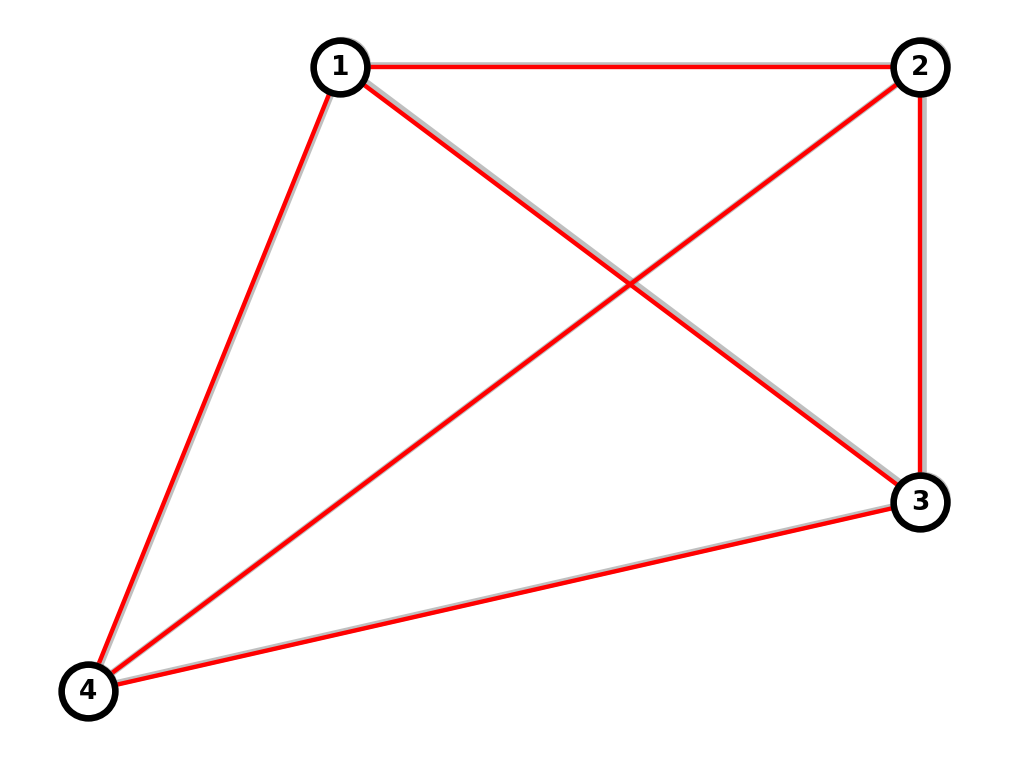

In [10]:
N = 4
G_new = nx.Graph()
G_new.add_nodes_from([1, 2, 3, 4])
G_new.add_edges_from([(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)])
b=np.sqrt(7/4)+np.sqrt(1/2)
zref_new = np.array([[1, 1], [np.sqrt(2), np.sqrt(2)], [1.5, 1.5], [1, 1], [b, b], [1.5, 1.5]])

control_new = SecondOrderControl(G_new,poses, zref_new)
control_new.draw_initial_conditions()

In [21]:
control_new.run_simulation()
control_new.plot_results(filename=join(output_dir,'simulations_animation_complete.gif'))

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABZpRtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DcxliIQAX/7yK/ApnClWwXcE/95SqYYGRT65kWsYAAADAAADAHOgAAGIgGDvjULyCXAE9UpXBtOz
nCf4b+TIII5zGeQ6Vde1Je7JXqR5aVbEHSOyPD+IFN9YngppAF8nZKkEtadfygeFHhUXLZMIexMA
7KOvXTKDsT3oUehhX1FUp593//QnUzeMhGVh2s1AQx3Rk4ZOle2SwN81gZWOWXqdPazdGTuJEbUA
qbEUfsOYTYiqHYKCBzjtRKEEAmRaRRXz5/8gRHex/Gnd8ADsPPQv2ED/JC7UGXQgaxFV8U9tTU3s
M2SQALm7oE/DYB3Wuw3/XKsbID4GoQtmVmfgryyuv0DfNu0cNztAIhpS6+6ymvZ5BjQSx5dgtE6Z
JXSIWFCg46Fa9QfjyK55rdwnLQ8axtPtK4mzCwM3b2w1IyPaYQlEt6Viem1QTXWXCLtc+NsZ+bsu
pSxmEoITNG3LStE53IlDN32T2Mt1TmsPJp/c0DhLY5999PtLgNIMQb/Aji+R+Mg0F+YCVII4eoJF
5WSEQ+R+W1Q5pTq19SKLICfeiB4Tje/h0+my/re7FcFw126kjshbrHeDAvvHRzxseooleUNOZ8ob
LLFYxZHtZpcq8VZcGfP5/sPKw4FBwGO47EzOwCP+4MdmWis/4Uo9ef24dv4gVswM2lNnHQe9Jxf0
q3tbxMHXVvVrR52H9AP9Hsbdp2mzigy/xMHqhT8a5K4FNZsrOBbu0IrTDi0fDj0C8Nt43UwSNebr
Y3h1rTGU9luX3fVFIfiNGVmIRmIqActChXfq4ysUqJQEMcTsQJX8va7aBMcTI3wcVT9R65Y3w0pQ
BLPeHQZUvrpAqgHFvKXBwyVzOjSGUXoK/itKtqCS/M3pkzFXN+O7z+2n1dO3I9qekc7dajP4Tcay
EwcaSItOTOWZ7hw+mYGuEKZgAOnzpMrgH6UNpJfvhtvlJ+FnoANwJA33197NUVvSmHSQEZRvYFkb
HcoNde2yO0AsTraMhtmVuoD3kPbWrXz6jy4txtacFl0gB3+QfEt0L6q0h1AaRIUJWJ6TWvNTmyT7
cQacYeX8pBS/7fAyLy0e+w+gBePp7FSxuN+r6RMAP4yWSQW739lRn0AWOmRDc4k1DirtI7/LQfIm
S+7mpc2zgAok2wWjOAO1VPIdTwVZAVsNmIdEft9vOL4ltUVizWg2sCFArIFo8fXVcCyb6FEFwLln
gP/+Qf8etdEyEAkCnk+vbeqGKPhA7q51B1z12gEKlihZeCmddS86pb0fEouGrAtMbdPvDbSTy3+r
+KvfOaBE9ItfUup/4Ac5TQAF7ABcYn77EDtg7i3Ny0bwyZIjpfL+xoKKVN0kg6wdukeNVEo9LiVD
U0xTd4l00u6p1vwYNl9Blo2E/Lf+44VoLcFzPe0dNM1XBzoX/br91LzzO1ooSvmh85y5NZzoWF9+
dCCH4Ma/WnNi0Lq6q3jRL8B0XWLlU+HxZa3UlN8fCOiASk6pZZDhajA/PyxT0uxex36vfMN0oY1+
UAwzazSk4w43yL/LJ/Bw8kbmcr2clv5siLy0Ck3/292gDVyl1kH/Sw6lNACwwJroCOkGHEveDuaX
6344iJfXEanY1RWUruZP3ebAKmKTtA1aJk01MotErFsqrsqb0u/626Dp4mwxy+TGhJ2CJ5cQ8xY1
Wr5Ou6ONHJs+euy+EDTyQ1Vl0Aiv7YK5HEi2moQDE3s4G8HFmFPL6DzLf4ZPQzAqdvH0srmDsZfK
rZNUL3O5z0nzoxeKwyAZ8vB2n0/ZGkjsnD2vkQOaCVQB59RRLYcQZc0yDwoV2EI9kfNjJaoRKxzA
A3wmvfrZIEeE1JHJ71PRhmzqV3DgaUViHMF6pw+vrcSFbXg5JPIBGgbnfFhXw6O1OD0AQ1j8QuWr
Kt8r9OPRg3XG/N3VktXNME+Hc05AQsEvzlVKicJVIoVV7mqHtg3Cf3Iz0u6Gh6X/qUUlPDtCf+AM
I/Pw7HgO7zI2rS+JfpQWLP5+GyGzbe1bT3nXMgiVDUYdJt2/lXwS/L4y/04ozzuc+IoQDYAx2tOF
d+hs/ezn2hORRwcVpReKAUACGgGkiVn/YaKkgBPMx7bhxmAvZcAatmfQ/OOzxvjh0COR8Zpm88nM
QWAfx5eXLPn98aX64mjmlz5LRnAGv6G3IhqBjazzy3sA+LifGzUXbEgUMWsffxTn0b/YUhCU9lBK
oo/gKeov2dUMrzVwW/LNdVjP6Z9YUxFyEj+8eSrTBQSLA4UIYfjzMYpjWIcb2A1RPy0UFMs9OEaJ
Ew5IL7cKeHNd6gy9x4kGFrOQjtLupRcuvfE/K0zj2ejuWJpvEX+AzVi1DBl9U5dXVx0P8IbbiX3Z
oZ4ynC5YvHJlIe913NhtxpZK5Gv6uV/49Hcg2yHqwNaqu6tpxx0vTejlvEcSkDSo/QwSGIIXnKn2
bWc3gDXoTdvjjdq6G6vEIp3MjbyNe9Sl/fsl2QkT0mJjToEpDaeOxDMy4GnhWJ08gj1fKnq1xNI3
mNPazgLOKbgi4lAGVKCF/db+9u7aTz4z/wBJnRuH1LljAIk2m3VzJJAG/Up2TF2xMtm2ZhDAJOq0
Qe0XgCRR/ip6bscwIUq/bOvk+mYZkNtADuVG02UfuDA+oodUrqqPIdbZIvL/x3ZJXgqfsG1x4n5e
r8RcfaWQ7D4xGGnb0FAP2I/NkXfx+7t3F+XQgZcbS2U1o56q0ekoNCJ0UM3Pd4ZzyE2DhRLIxHu6
BdP016+tGManBtFsIvJ83yjdXyEtRYfpfesaBeA1UUBxPPX2kiory/jjrGT+RhWcNBJ0vlRv4F3W
FUlHS0/35A1ygwxbBImXyLl0j7B45VrGLbhTRxaLcQKtM/eqd4IxBw4RulguPUAPMvUrHXV3c3GP
WjnDSLlVNRGqThIAUopoD